# Step 1. Data explore

This is a study case to use regression algorithm to predict 1 Hour EURUSD price movement.
In this step mainly cleaned the data and made a exploration.

Step 1. **Data exploration**

Step 2. [Feature engineering](/notebooks/forex/mark1/step%202%20-%20feature%20enginering.ipynb)

Step 3. [Data training and models evaluation](/notebooks/forex/mark1/step%203%20-%20training.ipynb)

In [19]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Set default font size
plt.rcParams['font.size'] = 24
plt.rcParams['figure.figsize'] = [16, 8]

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

csv_path = 'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019.csv'

In [20]:
# prepare date parser
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
# load csv
df = pd.read_csv(csv_path,
                 header=0,
                 index_col='Gmt time',
                 names=['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'],
                 parse_dates=['Gmt time'],
                 date_parser=dateparse)
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.index.rename('time', inplace=True)
print('Row count = %d' % len(df))
df.head(5)

Row count = 17952


,open,high,low,close,volume
time,,,,,
2017-05-01 00:00:00,1.09062,1.09081,1.08998,1.08998,2590.4500
2017-05-01 01:00:00,1.08998,1.09010,1.08895,1.08931,3752.0701
2017-05-01 02:00:00,1.08931,1.08970,1.08924,1.08942,2384.3999
2017-05-01 03:00:00,1.08941,1.08950,1.08915,1.08935,914.2400
2017-05-01 04:00:00,1.08935,1.08940,1.08904,1.08912,1391.0900


In [21]:
# inspect nan value
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

# Clean invalid row

In [22]:
# remove invalid candle
invalid_index = df[(df['high'] == df['low']) & (df['high'] == df['open']) &
                   (df['open'] == df['close']) & (df['volume'] == 0)].index
print('Invalid row count = %s'% len(invalid_index))

df = df.drop(invalid_index)
print('Row count = %d' % len(df))

Invalid row count = 5191
Row count = 12761


# Extract basic features

In [23]:
# hour
time = pd.Series(df.index, index=df.index)
hours = time.apply(lambda x: x.hour)
df['hour'] = hours
df.tail()

,open,high,low,close,volume,hour
time,,,,,,
2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16
2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17
2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18
2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19
2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20


In [24]:
# function to calculate pips
def pip(price=None, _abs=False):
    
    pip_unit = 0.0001
    if price:
        price = float(price)
        if _abs:
            price = abs(price)
        return (price / pip_unit)

    return pip_unit

In [25]:
volatility = df['high'] - df['low']
volatility = volatility.apply(lambda x: pip(x))
volatility
df['volatility'] = volatility
df.tail()

,open,high,low,close,volume,hour,volatility
time,,,,,,,
2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4
2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6
2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6
2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8
2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9


In [27]:
df.volatility.describe()

count    12761.000000
mean        14.090604
std          9.734775
min          0.800000
25%          7.600000
50%         11.800000
75%         17.700000
max        173.100000
Name: volatility, dtype: float64

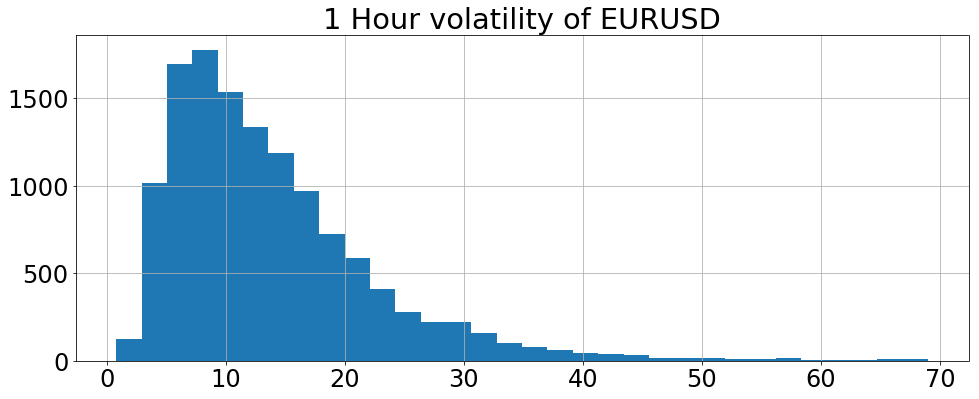

In [33]:
plt.title(r'1 Hour volatility of EURUSD')
df[df['volatility'] < 70].volatility.hist(bins=32,label='')

In [39]:
no_volume_len=len(df[df['volume']==0])
print('Row with no volume = %s, %.2f%%'% (no_volume_len,no_volume_len/len(df)*100))
df.volume.sort_values(ascending=False).head()

Row with no volume = 0, 0.00%


time
2019-02-14 09:00:00    252673.5469
2018-02-22 14:00:00    165915.0156
2017-09-22 13:00:00    163118.6563
2018-03-09 14:00:00    121364.8125
2018-11-23 08:00:00    116665.4297
Name: volume, dtype: float64

In [12]:
# Calculate first and third quartile
first_quartile = df['volume'].describe()['25%']
third_quartile = df['volume'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
dfv = df[(df['volume'] > 0) &
            (df['volume'] < (third_quartile + 3 * iqr))]

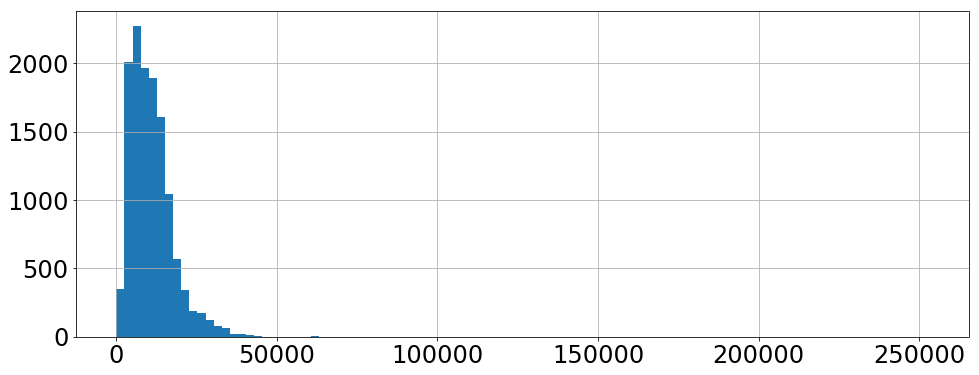

In [40]:
# drop that outlier and draw hist
dfv.volume.hist(bins=100)

# Hourly analysis


In [41]:
index = []
volume_data = []
volatility_data = []

for i in range(24):
    volume_desc = df[(df.hour == i)].volume.describe()
    volatility_desc = df[(df.hour == i)].volatility.describe()
    volume_sum=df[(df.hour == i)].volatility.sum()
    
    volume_data.append((i,volume_desc['mean'], volume_desc['std'], volume_desc['min'], volume_desc['25%'], volume_desc['50%'], volume_desc['75%'], volume_desc['max'],volume_sum))
    volatility_data.append((i,volatility_desc['mean'], volatility_desc['std'], volatility_desc['min'], volatility_desc['25%'], volatility_desc['50%'], volatility_desc['75%'], volatility_desc['max']))
volume_df = pd.DataFrame(volume_data, columns=['hour','mean', 'std', 'min', '25%', '50%', '75%', 'max','sum'])
volume_df = volume_df.set_index('hour')
volatility_df = pd.DataFrame(volatility_data, columns=['hour','mean', 'std', 'min', '25%', '50%', '75%', 'max'])
volatility_df = volatility_df.set_index('hour')

In [42]:
volume_df.head(3)

,mean,std,min,25%,50%,75%,max,sum
hour,,,,,,,,
0,7334.668837,2284.918410,623.26,5902.2300,7080.9302,8599.6396,18460.6900,5813.8
1,7917.911630,2647.115303,340.87,6189.5698,7653.5698,9361.1904,19531.6699,5971.9
2,6863.439144,2495.402259,292.24,5153.1099,6441.0498,8121.8799,20431.8906,4939.2


Text(0.5, 1.0, 'EURUSD Hourly volume')

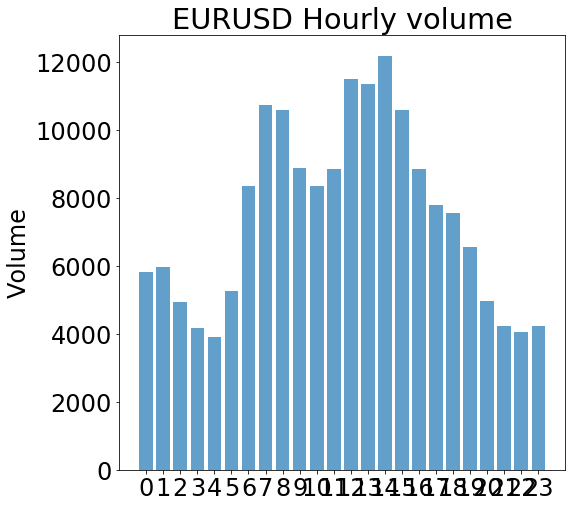

In [44]:
# Hourly volume
figsize(8, 8)

plt.bar(volume_df.index, volume_df['sum'], align='center', alpha=0.7)
plt.ylabel('Volume')
plt.xticks(volume_df.index, range(24))
plt.title('EURUSD Hourly volume')

Text(0.5, 1.0, 'EURUSD Hourly Volatility')

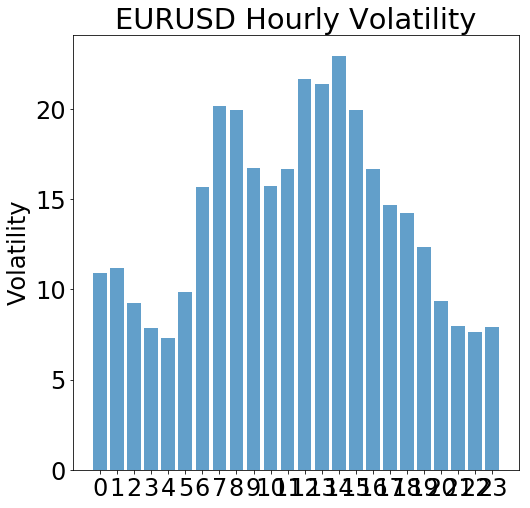

In [45]:
# Hourly volatility
figsize(8, 8)

plt.bar(volatility_df.index, volatility_df['mean'], align='center', alpha=0.7)
plt.ylabel('Volatility')
plt.xticks(volatility_df.index, range(24))
plt.title('EURUSD Hourly Volatility')

# Save data for next step

In [46]:
df.to_csv('data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_cleaned.csv', float_format='%.5f')